In [1]:
import logging 
from collections import namedtuple
import random 
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor 
from collections import Counter
import numpy as np 
from functools import cache, lru_cache
import  matplotlib.pyplot as plt


In [2]:
Nimply = namedtuple("Nimply",["row", "num_objects"])

In [3]:

class Nim:
    def __init__(self, num_rows: int, k: int = 100) -> None:
        self._rows =[i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    def __eq__(self, other : object) -> bool:
        if isinstance(other, Nim): 
            return Counter(other.rows) == Counter(tuple(self._rows))
        else : 
            return False 
    @property
    def rows(self) :
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

PURE RANDOM

In [125]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result
def isPowerOfTwo (x):
    if x == 0 :
        return 5
    if x == 1 : 
        return False
    # First x in the below expression
    # is for the case when x is 0
    return (x and (not(x & (x - 1))) )
def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]

    brute_force = list()
    try :
        cooked['min_non_power_two'] =  min([x  for x in enumerate(state.rows) if not isPowerOfTwo(x[1])],key = lambda y: y[1] )[0]
    except ValueError : 
        cooked['max_non_power_two'] = None
        cooked['min_non_power_two'] = None
    
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force
    cooked['twos'] = None
    if cooked["active_rows_number"] == 3 : 
        for m in cooked["possible_moves"]:
             tmp = deepcopy(state)
             tmp.nimming(m)
             a = Counter(tmp.rows)
             if 2 or 3 in list(a.elements()):
                 cooked["twos"] = m
    return cooked

In [126]:
def possible_moves(state : Nim)-> list : 

        return [Nimply(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k]
        

In [6]:
from abc import ABC , abstractmethod
class Agent(ABC): 
    @abstractmethod
    def choose_action():pass
    

OPTIMAL AGENT

In [7]:
class optimal_agent(Agent):
    def nim_sum(self,state:Nim) -> int:
        *_, result = accumulate(state.rows, xor)
        return result
    
    def choose_action(self,state:Nim):
        brute_force = list()
        for m in possible_moves(state):
           tmp = deepcopy(state)
           tmp.nimming(m)
           brute_force.append((m, self.nim_sum(tmp)))
        return next((bf for bf in brute_force if bf[1] == 0), random.choice(brute_force))[0]
    
      

RANDOM AGENT

In [8]:
class random_agent(Agent): 
    def choose_action(self,state:Nim):
        row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
        num_objects = random.randint(1, state.rows[row])
        return Nimply(row, num_objects)

TASK 1 : expert system

Dummy Nim Sum

EXPERT AGENT

In [116]:
class expert_strategy(Agent):
    def __init__(self,genome : dict ):
        self.genome = genome 
    def choose_action(self,state:Nim)-> Nimply : 
         
          
        data = cook_status(state)
        arn= data["active_rows_number"]
        if arn  > 3 : 
            if random.random() < self.genome["p"]: 
                ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))
            else : 
                if data["active_rows_number"]//2 !=0: 
                    if data["min_non_power_two"] != None:
                        ply = Nimply(data["min_non_power_two"],state.rows[data["min_non_power_two"]])
                    else :
                        ply = Nimply(data["shortest_row"], state.rows[data["shortest_row"]])
                else : 
                        ply = Nimply(data["longest_row"], state.rows[data["longest_row"]]-1)
        if arn == 3 :
            if random.random() < self.genome["q"]:
                if data["twos"] != None : 
                    ply = Nimply(data['twos'][0],data['twos'][1])
                else : 
                    ply = Nimply(data["longest_row"],state.rows[data["longest_row"]]-1)
            else : 
                    ply = Nimply(data["longest_row"],state.rows[data["longest_row"]]-1)
        
        if arn ==2 : 
                ply = Nimply(data["longest_row"],1)
                      
        if arn == 1 : 
                ply = Nimply(data["longest_row"], state.rows[data['longest_row']])
        
        
        return ply

    


In [123]:


def Play_Nim(player1 : classmethod , player2:classmethod,NIM_SIZE):

    strategy = (player1,player2)
    logging.info(f"PLAYER 1 : {player1.__class__.__name__}")
    logging.info(f"PLAYER 2 : {player2.__class__.__name__}")
    nim = Nim(NIM_SIZE)
    logging.debug(f"status: Initial board  -> {nim}")
    player = 0
    while nim:
        ply = strategy[player].choose_action(nim)
        nim.nimming(ply)
        logging.debug(f"status: After player {player} -> {nim}")
        player = 1 - player
    winner = 1 - player
    logging.info(f"status: Player {winner+1} ({strategy[winner].__class__.__name__}) won!")

In [54]:



def evaluate(player1: classmethod, player2:classmethod, NIM_SIZE,NUM_MATCHES) -> float:
    opponent = (player1,player2)
    won = 0

    for m in range(NUM_MATCHES):
        nim = Nim(NIM_SIZE)
        player = 0
        while nim:

            ply = opponent[player].choose_action(nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 1:
            won += 1
    
    return won / NUM_MATCHES

In [55]:
logging.getLogger().setLevel(logging.DEBUG)
ratio = evaluate(expert_strategy({"p": 0.5, "q":0.5}),random_agent(),5,100)
logging.info(f"PLAYER 1  have won {ratio} of matches  ")

INFO:root:PLAYER 1  have won 0.83 of matches  


In [164]:
Inidividual = namedtuple("Individual", ["genome","fitness"])
PROBLEM_SIZE = 2 
POPULATION_SIZE = 30
def fitness(genome) -> float:
    NIM_SIZES = [3,4,5]
    fitness = 0
    for i in NIM_SIZES:
        fitness+=evaluate(expert_strategy({"p":genome[0],"q":genome[1]}),random_agent(),i,100)
    return fitness
def tournament(population, tourrnament_size=2): 
    return max(random.choices(population, k = tourrnament_size), key = lambda x : x.fitness)

def cross_over(g1,g2): 
    child = tuple()
    for i, j in zip(g1,g2):
        child+=((i+j)/2,) 
    return child


def mutation(child ): 
    choice = random.choice([0,1])
    return child[:choice] + (random.random(),) + child[choice + 1 :]

    

TASK 2 : evolved rules

Initial Population

In [165]:
population = list()

for genome in [tuple( [random.random() for _ in range(PROBLEM_SIZE)] ) for _ in range(POPULATION_SIZE)]:
    population.append(Inidividual(genome ,fitness(genome)))
    
logging.info(f"init: pop_size={len(population)}; max={max(population, key=lambda i: i.fitness)[1]}")

INFO:root:init: pop_size=30; max=2.63


GA

In [58]:
fitness_log = [(0,i.fitness) for i in population]
NUM_GENETATIONS = 300
OFF_SPRING = 3
for g in range(NUM_GENETATIONS): 
    offspring = list()
    for i in range(OFF_SPRING): 
        if random.random()<0.5 : 
            p = tournament(population)

            c = mutation(p.genome)
        

        else  : 
            p1 =tournament(population)
            p2 =tournament(population)
            c = cross_over(p1.genome , p2.genome)


        f = fitness(c)
        fitness_log.append((g+1,f))
        offspring.append(Inidividual(c,f))
    population+=offspring
    population = sorted(population , key = lambda x :x.fitness , reverse=True)[:POPULATION_SIZE]
    logging.info(f"GENRATION {g}, BEST FITNESS {population[0].fitness}")
    

INFO:root:GENRATION 0, BEST FITNESS 2.63
INFO:root:GENRATION 1, BEST FITNESS 2.63
INFO:root:GENRATION 2, BEST FITNESS 2.63
INFO:root:GENRATION 3, BEST FITNESS 2.63
INFO:root:GENRATION 4, BEST FITNESS 2.63
INFO:root:GENRATION 5, BEST FITNESS 2.63
INFO:root:GENRATION 6, BEST FITNESS 2.63
INFO:root:GENRATION 7, BEST FITNESS 2.63
INFO:root:GENRATION 8, BEST FITNESS 2.63
INFO:root:GENRATION 9, BEST FITNESS 2.63
INFO:root:GENRATION 10, BEST FITNESS 2.7
INFO:root:GENRATION 11, BEST FITNESS 2.7
INFO:root:GENRATION 12, BEST FITNESS 2.7
INFO:root:GENRATION 13, BEST FITNESS 2.73
INFO:root:GENRATION 14, BEST FITNESS 2.73
INFO:root:GENRATION 15, BEST FITNESS 2.73
INFO:root:GENRATION 16, BEST FITNESS 2.73
INFO:root:GENRATION 17, BEST FITNESS 2.73
INFO:root:GENRATION 18, BEST FITNESS 2.73
INFO:root:GENRATION 19, BEST FITNESS 2.73
INFO:root:GENRATION 20, BEST FITNESS 2.73
INFO:root:GENRATION 21, BEST FITNESS 2.73
INFO:root:GENRATION 22, BEST FITNESS 2.73
INFO:root:GENRATION 23, BEST FITNESS 2.73
INFO:

In [60]:
EG = population[0].genome


EVOLVED VS NON-EVVOLVED

In [143]:
logging.getLogger().setLevel(logging.DEBUG)
logging.info(f"----EVOLVED GOES FIRST----")
ratio=evaluate(expert_strategy({"p":EG[0] , "q":EG[1]}),expert_strategy({"p": 0.5, "q":0.5}),5,100)
logging.info(f"PLAYER 1  have won {ratio} of matches  ")
logging.info(f"----NON EVOLVED GOES FIRST----")
ratio=evaluate(expert_strategy({"p":0.5 , "q":0.5}),expert_strategy({"p": EG[0], "q":EG[1]}),5,100)
logging.info(f"PLAYER 1  have won {ratio} of matches  ")



INFO:root:----EVOLVED GOES FIRST----
INFO:root:PLAYER 1  have won 0.74 of matches  
INFO:root:----NON EVOLVED GOES FIRST----
INFO:root:PLAYER 1  have won 0.36 of matches  


EVOLVED VS RANDOM

In [144]:
NIM_SIZE = 5
ratio = evaluate(expert_strategy({"p":EG[0],"q":EG[1]}),random_agent(),NIM_SIZE,100)
logging.info(f"PLAYER 1  have won {ratio} of matches ")


INFO:root:PLAYER 1  have won 0.92 of matches 


EVOLVED VS OPTIMAL

In [145]:
NIM_SIZE = 5
ratio = evaluate(expert_strategy({"p":EG[0],"q":EG[1]}),optimal_agent(),NIM_SIZE,100)
logging.info(f"PLAYER 1  have won {ratio} of matches ")

INFO:root:PLAYER 1  have won 0.0 of matches 


TASK 3 : MinMax

In [146]:

def minmax(state : Nim, MaximizingPlayer : bool): 
    if not state :  
        return 1 if MaximizingPlayer else -1

    stats = possible_moves(state)


    if MaximizingPlayer : 
        maxEval = -np.inf
        for child in stats: 
            tmp_max = deepcopy(state)
            tmp_max.nimming(child)

            evaluation = minmax(tmp_max  , False )
            maxEval = max(maxEval ,evaluation)
        return maxEval
    else  : 
        minEval = + np.inf ; 
        for child in  stats: 
            tmp_min = deepcopy(state)
            tmp_min.nimming(child)

            evaluation = minmax(tmp_min  , True)
            minEval = min(minEval, evaluation)
        return minEval 
    
            

In [86]:
nim = Nim(3)
result = minmax(nim ,True)
print(result)

1


In [147]:

def alpha_beta(state:Nim ,alpha : float, beta:float,  MaximizingPlayer : bool)-> int:

    decisions = list()
    moves = possible_moves(state)
    if not state :  
        return (None,1) if not MaximizingPlayer else (None,-1)


    
    if MaximizingPlayer : 
        maxEval = - np.inf

        for i in  moves : 
            
            tmp_max = deepcopy(state)
            tmp_max.nimming(i)
            _,evaluation = alpha_beta(tmp_max , alpha , beta , False)
            decisions.append((i,evaluation))
            
            #maxEval = max(maxEval , evaluation)
            alpha = max(alpha, evaluation)
            if beta <= alpha : 

                break  

        return max(decisions,key= lambda y:y[1])
    else : 
        minEval = np.inf

        for i in moves : 
            tmp_min = deepcopy(state)
            tmp_min.nimming(i)
            _,evaluation = alpha_beta(tmp_min, alpha ,beta , True)
            decisions.append((i,evaluation))
            #minEval = min(minEval , evaluation)
            beta = min(beta,evaluation)
            if beta <= alpha : 

                break  
        return min(decisions,key= lambda y:y[1])
    


In [148]:
logging.getLogger().setLevel(logging.DEBUG)
nim = Nim(3)
a = alpha_beta(nim ,-np.inf, np.inf,True)
print(a)
if a : 
    logging.info("You Won Congrats")
else : 
    logging.info("You Lost Dumbass")


INFO:root:You Won Congrats


(Nimply(row=2, num_objects=3), 1)


In [160]:
class min_max_strategy(Agent):
 

    def choose_action(self,state:Nim): 
        return alpha_beta(state,-np.inf, np.inf,True)[0]


MIN MAX VS RANDOM

In [161]:
NIM_SIZE = 3

ratio = evaluate(min_max_strategy(), random_agent(),NIM_SIZE,100)
logging.info(f"PLAYER 1  have won {ratio} of matches ")


INFO:root:PLAYER 1  have won 1.0 of matches 


MIN MAX VS OPTIMAL STRATEGY

In [162]:
NIM_SIZE = 3
ratio = evaluate(min_max_strategy(),optimal_agent(),NIM_SIZE,100)
logging.info(f"PLAYER 1  have won {ratio} of matches ")

INFO:root:PLAYER 1  have won 1.0 of matches 


In [166]:
from math import exp 
class  Q_leaning:
    def __init__(self, alpha , gamma , epsilon, temp_start,train: bool):
        self.epsilon = epsilon
        self.gamma = gamma 
        self.alpha = alpha
        self.Q = dict()
        self.prevS = self.prevA = None
        self.WIN_REWARD , self.LOSS_REWARD = 1,-1
        self.temp = temp_start
        self.train = train

        self.history = list()
    def annealing(self,update_temp = lambda x : x*0.995)-> float:
            a = exp(- 0.001/ self.temp)
            self.temp = update_temp(self.temp)
            return a
    def SaveQ(self,currS :Nim)->None:
        possible_actions = possible_moves(currS)
        if (currS.rows,possible_actions[0]) not  in self.Q: 
            for action in possible_actions : 
                self.Q[(currS.rows,action)] = np.random.uniform(0.0,0.01)
    
    def choose_action(self, currS,random_factor): 
        possible_actions = possible_moves(currS)
       
        if np.random.random() > random_factor and self.train: 
            
            Q_value = [self.Q[(currS.rows , action)] for action in possible_actions]
            return possible_actions[np.argmax(Q_value)]
        elif not self.train : 
            if (currS.rows,possible_actions[0]) not  in self.Q: 
                 self.SaveQ(currS)
            Q_value = [self.Q[(currS.rows , action)] for action in possible_actions ]
            return possible_actions[np.argmax(Q_value)]     
              
        else: 

            return random.choice(possible_actions)
    

    def learn(self,currS, random_factor): 
        if not currS: 
            self.Q[(self.prevS.rows, self.prevA)] += self.alpha *(self.LOSS_REWARD - self.Q[(self.prevS.rows, self.prevA)])
            currA = self.prevS = self.prevA = None
        else : 

            self.SaveQ(currS)
            currA = self.choose_action(currS, random_factor)
            if self.prevA is not None: 
                nextS = deepcopy(currS)
                nextS.nimming(currA)
                
                reward = 0 if nextS else self.WIN_REWARD 
                
                maxQ = max(self.Q[(currS.rows, action)] for action in possible_moves(currS))
                self.Q[(self.prevS.rows,self.prevA)] +=self.alpha *(reward+self.gamma*maxQ - self.Q[(self.prevS.rows,self.prevA)])
            self.prevS, self.prevA = deepcopy(currS) , deepcopy(currA)

        return currA
                
                 

In [167]:
from math import exp 
class  SARSA:
    def __init__(self, alpha , gamma , epsilon, temp_start, train : bool):
        self.epsilon = epsilon
        self.gamma = gamma 
        self.alpha = alpha
        self.Q = dict()
        self.prevS = self.prevA = None
        self.WIN_REWARD , self.LOSS_REWARD = 1,-1
        self.temp = temp_start
        self.train = train

        self.history = list()
    def annealing(self,update_temp = lambda x : x*0.995)-> float:
            a = exp(- 0.001/ self.temp)
            self.temp = update_temp(self.temp)
            return a
    def SaveQ(self,currS :Nim)->None:
        possible_actions = possible_moves(currS)
        if (currS.rows,possible_actions[0]) not  in self.Q: 
            for action in possible_actions : 
                self.Q[(currS.rows,action)] = np.random.uniform(0.0,0.1)
    
    def choose_action(self, currS,random_factor): 
        possible_actions = possible_moves(currS)
       
        if np.random.random() > random_factor and self.train: 
            
            Q_value = [self.Q[(currS.rows , action)] for action in possible_actions ]
            return possible_actions[np.argmax(Q_value)]
        elif not self.train : 
            if (currS.rows,possible_actions[0]) not  in self.Q: 
                self.SaveQ(currS)
            Q_value = [self.Q[(currS.rows , action)] for action in possible_actions ]
            return possible_actions[np.argmax(Q_value)]
        else: 

            return random.choice(possible_actions)
    

    def learn(self,currS, random_factor): 
        if not currS: 
            self.Q[(self.prevS.rows, self.prevA)] += self.alpha *(self.LOSS_REWARD - self.Q[(self.prevS.rows, self.prevA)])
            currA = self.prevS = self.prevA = None
        else : 

            self.SaveQ(currS)
            currA = self.choose_action(currS, random_factor)
            if self.prevA is not None: 
                nextS = deepcopy(currS)
                nextS.nimming(currA)
                reward = 0 if  nextS else self.WIN_REWARD 

                self.Q[(self.prevS.rows,self.prevA)] +=self.alpha *(reward+self.gamma*self.Q[(currS.rows,currA)] - self.Q[(self.prevS.rows,self.prevA)])
            self.prevS, self.prevA = deepcopy(currS) , deepcopy(currA)

        return currA
                
                 

In [171]:


def train_v1( initS :Nim,player1 : classmethod, player2: classmethod, NUM_MATCHES): 
        rateHistory = []
        indices = []
        win_ratio = 0
        for match in range(NUM_MATCHES): 
            currS = deepcopy(initS)

            random_factor= player1.annealing()
            player1.history.clear()
            while True : 
                # P1 turn 
                P1_action = player1.learn(currS , random_factor)
                if P1_action is None : 
                    break 
                currS.nimming(P1_action)
                if not currS : 
                    win_ratio +=1
                    break 
                

                # P2 turn 
                P2_action =player2.choose_action(currS)

                currS.nimming(P2_action)
        
            if match % 100 == 0:
                rateHistory.append(win_ratio / 100)
                indices.append(match)
                win_ratio = 0


        plt.semilogy(indices, rateHistory, "b")
        plt.title(f"{player1.__class__.__name__}")
        plt.show()



                

In [172]:
def Play(initS :Nim,player1 : classmethod, player2: classmethod, NUM_MATCHES): 
    win_ratio = 0 
    for match in range(NUM_MATCHES): 
            currS = deepcopy(initS)
            random_factor = 0

            while True : 
                # P1 turn 
                P1_action = player1.choose_action(currS , random_factor)
                
                currS.nimming(P1_action)
                if not currS : 
                    win_ratio +=1
                    break 
                

                # P2 turn 
                P2_action =player2.choose_action(currS)

                currS.nimming(P2_action)
                if not currS: 
                    break
    return win_ratio/NUM_MATCHES
            

DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.

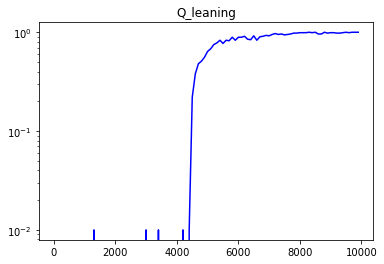

ratio : 0.9955


In [173]:
Q_agent=Q_leaning(0.15,0.99,0.25,7500,True)
opt_agent = optimal_agent()
nim = Nim(5)
train_v1(nim,Q_agent,opt_agent,10_000)

Q_agent.train = False
nim = Nim(5)
ratio_test = Play(nim,Q_agent , opt_agent, 10_000)

print(f"ratio : {ratio_test}")

DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.007943282347242814 vmax 1.2589254117941673
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.

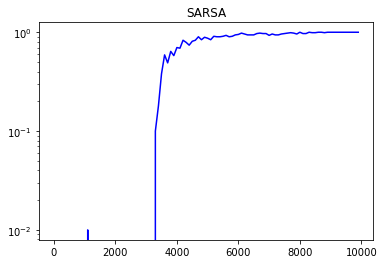

ratio : 0.996


In [174]:
sarsa_agent = SARSA(0.15,0.99,0.25,7500, True )
opt_agent = optimal_agent()
nim = Nim(5)
train_v1(nim,sarsa_agent,opt_agent,10_000)

sarsa_agent.train = False 
nim = Nim(5)
ratio_test = Play(nim,sarsa_agent, opt_agent, 10_000)

print(f"ratio : {ratio_test}")

In [273]:
import numpy as np




class RL_Agent(object):
    def __init__(self,temp_start, alpha, train :bool ):  # 80% explore, 20% exploit
        self.state_history = []  # state, reward
        self.alpha = alpha

        self.G = {}
        self.temp = temp_start
        self.train = train
        
    def annealing(self,update_temp = lambda x : x*0.995)-> float:
            a = exp(- 0.001/ self.temp)
            self.temp = update_temp(self.temp)
            return a
    
    def registerG(self, state):
       
        possible_actions = possible_moves(state)
        if state.rows not  in self.G.keys(): 
                self.G[state.rows] = np.random.uniform(0.0,0.00001)
            

    def choose_action(self, state, random_factor):
        possible_actions = possible_moves(state)
        maxG = -10e15
       
        if np.random.random() > random_factor and self.train  : 
            for action in possible_actions : 
                new_state = deepcopy(state)
                new_state.nimming(action)
                self.registerG(new_state)
                if self.G[new_state.rows] >= maxG:
                    next_move = action
                    maxG = self.G[new_state.rows]
            return next_move
        
        elif not  self.train  : 
            for action in possible_actions : 
                new_state = deepcopy(state)
                new_state.nimming(action)
                self.registerG(new_state)
                if self.G[new_state.rows] >= maxG:
                    next_move = action
                    maxG = self.G[new_state.rows]
            return next_move
        
        else  : 

                action = random.choice(possible_actions)

                new_state = deepcopy(state)
                new_state.nimming(action)

                self.registerG(new_state)
                return action
 

    def update_state_history(self, state, reward):
        self.state_history.append((state.rows, reward)) 

    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []




In [276]:
def train(player1: classmethod, player2: classmethod,NUM_MATCHES):

    NIM_NUM = 5
    nim = Nim(NIM_NUM)
    rateHistory = []
    indices = []
    win_ratio = 0
    player1.registerG(nim)
    for match in range(NUM_MATCHES):
        random_factor = player1.annealing()
        player1.update_state_history(nim,0)
        while True:

            action = player1.choose_action(nim,random_factor)
            nim.nimming(action)
            reward = 0 if nim else 1 
            player1.update_state_history(nim, reward)
            if not nim : 
                win_ratio +=1

                break 

            
            action =player2.choose_action(nim)
            nim.nimming(action)
            if not nim : 
                break 


        player1.learn()
        if match % 100 == 0:
            rateHistory.append(win_ratio / 100)
            indices.append(match)
            win_ratio = 0
        nim = Nim(NIM_NUM)

    plt.semilogy(indices, rateHistory, "b")
    plt.title(f"{player1.__class__.__name__}")
    plt.show()

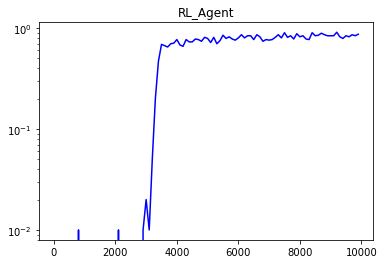

0.8435


In [277]:
agent = RL_Agent(7500,0.1,True)
train(agent,optimal_agent(),10_000)

agent.train = False 
ratio = Play(Nim(5),agent,optimal_agent(),10_000)
print(ratio)

TypeError: dict.keys() takes no arguments (1 given)